In [1]:
import pandas as pd
import os
import env
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split


import wrangle as w
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = w.wrangle_zillow()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50677 entries, 0 to 50676
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   parcelid                    50677 non-null  int64  
 1   logerror                    50677 non-null  float64
 2   bathrooms                   50677 non-null  float64
 3   bedrooms                    50677 non-null  float64
 4   sq_feet                     50677 non-null  float64
 5   fips                        50677 non-null  float64
 6   latitude                    50677 non-null  float64
 7   longitude                   50677 non-null  float64
 8   lotsizesquarefeet           50677 non-null  float64
 9   regionidcity                50677 non-null  float64
 10  regionidcounty              50677 non-null  float64
 11  regionidzip                 50677 non-null  float64
 12  year_built                  50677 non-null  float64
 13  structuretaxvaluedollarcnt  506

In [4]:
train, validate, test = w.split_data(df)

In [5]:
#train.head(3)

In [6]:
#train.info()

In [7]:
train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test)

In [8]:
#validate_scaled.info()

In [9]:
#validate_scaled[['bedrooms','bathrooms','sq_feet']].info()

In [10]:
#X_validate_scaled = validate_scaled[['bedrooms','bathrooms','sq_feet']]

In [11]:
#X_validate_scaled.info()

In [12]:
#train_scaled.info()

In [13]:
# list of variables I will cluster on. 
cluster_vars = ['bedrooms','bathrooms', 'sq_feet']
cluster_name = 'interior_cluster1'
k_range = range(2,20)

In [14]:
X_train = train_scaled[['bedrooms','bathrooms', 'sq_feet']]

In [15]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df


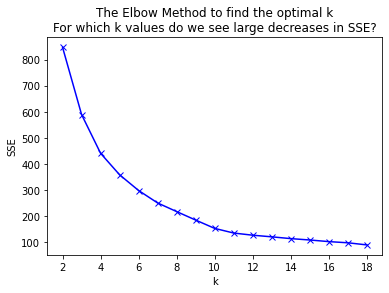

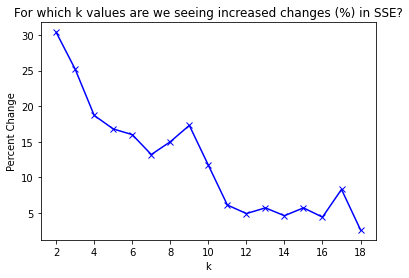

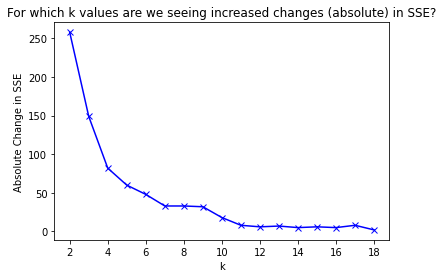

In [16]:
k_comparisons_df = find_k(X_train, cluster_vars, k_range)

In [17]:
k_comparisons_df

,k,sse,delta,pct_delta
0,2,847.181986,258.0,30.4
1,3,589.352789,149.0,25.2
2,4,440.679429,82.0,18.7
3,5,358.198913,60.0,16.8
4,6,297.978122,48.0,16.0
5,7,250.200181,33.0,13.2
6,8,217.187421,33.0,15.0
7,9,184.639392,32.0,17.3
8,10,152.765661,18.0,11.7
9,11,134.962615,8.0,6.1


In [18]:
def create_clusters(X_train, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 123)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans


# working with k = 6

In [19]:
kmeans = create_clusters(X_train, 6, cluster_vars)

In [20]:
kmeans

KMeans(n_clusters=6, random_state=123)

In [21]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df


In [22]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

In [23]:
centroid_df

,interior_cluster1,centroid_bedrooms,centroid_bathrooms,centroid_sq_feet
0,0,0.640606,0.632983,0.432259
1,1,0.510666,0.173529,0.166290
2,2,0.221873,0.003030,0.093555
3,3,0.308121,0.170163,0.139503
4,4,0.541758,0.349059,0.255575
5,5,0.322810,0.336326,0.227642


In [24]:
# label cluster for each observation in X_train (X[0] in our X list of dataframes), 
# X_validate (X[1]), & X_test (X[2])

def assign_clusters(df, kmeans, cluster_vars, cluster_name, centroid_df):
    #for i in range(len(df)):
        clusters = pd.DataFrame(kmeans.predict(df[cluster_vars]), 
                            columns=[cluster_name], index=df.index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        df = pd.concat([df, clusters_centroids], axis=1)
        return df


In [25]:
X2 = assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)

In [26]:
X2.head()

,bedrooms,bathrooms,sq_feet,interior_cluster1,centroid_bedrooms,centroid_bathrooms,centroid_sq_feet
40409,0.333333,0.416667,0.275165,5,0.32281,0.336326,0.227642
23172,0.500000,0.500000,0.269389,5,0.32281,0.336326,0.227642
49707,0.500000,0.333333,0.195132,5,0.32281,0.336326,0.227642
36587,0.500000,0.333333,0.151609,5,0.32281,0.336326,0.227642
6405,0.333333,0.166667,0.092616,5,0.32281,0.336326,0.227642


In [27]:
pd.DataFrame(X2.groupby(['interior_cluster1', 'centroid_bedrooms','centroid_bathrooms', 'centroid_sq_feet'])['interior_cluster1'].count())


,,,,interior_cluster1
interior_cluster1,centroid_bedrooms,centroid_bathrooms,centroid_sq_feet,
0,0.640606,0.632983,0.432259,1618
1,0.510666,0.173529,0.166290,4156
2,0.221873,0.003030,0.093555,5253
3,0.308121,0.170163,0.139503,9713
4,0.541758,0.349059,0.255575,4982
5,0.322810,0.336326,0.227642,2656


In [28]:
train_clusters = pd.concat([train, X2['interior_cluster1']], axis=1)

In [29]:
#train_clusters

## Count of observations in interior_cluster1 clusters

In [30]:
pd.DataFrame(train_clusters.groupby(['interior_cluster1'])['interior_cluster1'].count())



,interior_cluster1
interior_cluster1,
0,1618
1,4156
2,5253
3,9713
4,4982
5,2656


In [31]:
#sns.scatterplot(train_clusters.bedrooms, train_clusters.logerror, hue=train_clusters.interior_cluster1)

In [32]:
#sns.scatterplot(train_clusters.sq_feet, train_clusters.logerror, hue=train_clusters.interior_cluster1)

In [33]:
#train_clusters[train_clusters.interior_cluster1 == 2]

In [34]:
#sns.scatterplot(train_clusters[train_clusters.interior_cluster1 == 2].bedrooms, train_clusters[train_clusters.interior_cluster1 == 2].logerror, hue=train_clusters.interior_cluster1)

In [35]:
#sns.scatterplot(train_clusters[train_clusters.interior_cluster1 == 1].bath_bed_ratio, train_clusters[train_clusters.interior_cluster1 == 1].logerror, hue=train_clusters.interior_cluster1)

In [36]:
#plt.hist(train_clusters[train_clusters.interior_cluster1 == 0]['logerror'])

In [37]:
#plt.figure(figsize=(12,6))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
#plt.scatter(y=train_clusters.logerror, x=train_clusters.sq_feet, c=train_clusters.interior_cluster1, alpha=.4)
#plt.set(title='logerror vs sq_feet'.format(k), xlabel='sq_feet', ylabel='logerror')
#plt.legend()

In [38]:
train_clusters[train_clusters.interior_cluster1 == 0]['logerror'].abs().mean()

0.06955233626697876

In [39]:
train_clusters[train_clusters.interior_cluster1 == 1]['logerror'].abs().mean()

0.07340950934656182

In [40]:
train_clusters[train_clusters.interior_cluster1 == 2]['logerror'].abs().mean()

0.07141700710014462

In [41]:
train_clusters[train_clusters.interior_cluster1 == 3]['logerror'].abs().mean()

0.07177977686117148

In [42]:
train_clusters[train_clusters.interior_cluster1 == 4]['logerror'].abs().mean()

0.07283631756264358

In [43]:
train_clusters[train_clusters.interior_cluster1 == 5]['logerror'].abs().mean()

0.06679235351584653

In [44]:
train_clusters['logerror_abs'] = train_clusters.logerror.abs()

In [45]:
#train_clusters.info()

In [46]:
train_clusters.logerror_abs.mean()

0.07154299587388376

In [47]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster1 == 0]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(-0.604608397743315, 0.5455240512585082)

In [48]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster1 == 1]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(0.7042935823893388, 0.4812894325068775)

In [49]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster1 == 2]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(-0.05689408183184019, 0.9546317329688915)

In [50]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster1 == 3]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(0.14700772591190797, 0.8831289735797647)

In [51]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster1 == 4]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(0.5832604461441707, 0.5597443914836405)

In [52]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster1 == 5]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(-1.913911091384167, 0.05573892393122242)

# working with k=7

In [53]:
# list of variables I will cluster on. 

cluster_name = 'interior_cluster2'
#k_range = range(2,20)

In [54]:
kmeans = create_clusters(X_train, 7, cluster_vars)

In [55]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

In [56]:
X = assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)

In [57]:
train_clusters = pd.concat([train_clusters, X['interior_cluster2']], axis=1)

In [58]:
pd.DataFrame(train_clusters.groupby(['interior_cluster2'])['interior_cluster2'].count())



,interior_cluster2
interior_cluster2,
0,2407
1,4133
2,4964
3,2495
4,1563
5,8219
6,4597


In [59]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster2 == 0]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(-0.07423210605327785, 0.9408318702105614)

In [60]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster2 == 1]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(-0.9856321106117554, 0.324371384299427)

In [61]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster2 == 2]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(0.6526420604947348, 0.5140172908361859)

### cluster 3 is significant!!!

In [62]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster2 == 3]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(-2.1197842788028, 0.03412275941003845)

In [63]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster2 == 4]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(-0.4263377160673346, 0.6699205242811842)

In [64]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster2 == 5]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(0.3590621329545367, 0.7195578333051393)

In [65]:
t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster2 == 6]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

(1.0989916092661203, 0.27182929090501273)

# working with k5

# list of variables I will cluster on. 

cluster_name = 'interior_cluster3'
#k_range = range(2,20)

kmeans = create_clusters(X_train, 5, cluster_vars)

centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

X = assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)

train_clusters = pd.concat([train_clusters, X['interior_cluster3']], axis=1)

pd.DataFrame(train_clusters.groupby(['interior_cluster3'])['interior_cluster3'].count())



t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster3 == 0]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster3 == 1]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster3 == 2]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster3 == 3]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster3 == 4]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

# working with k8

cluster_name = 'interior_cluster4'
kmeans = create_clusters(X_train, 8, cluster_vars)
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)
X = assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)
train_clusters = pd.concat([train_clusters, X['interior_cluster4']], axis=1)
pd.DataFrame(train_clusters.groupby(['interior_cluster4'])['interior_cluster4'].count())

t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster4 == 0]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster4 == 1]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster4 == 2]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster4 == 3]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster4 == 4]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

### cluster 5 is significant

t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster4 == 5]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster4 == 6]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

t, p = stats.ttest_1samp((train_clusters[train_clusters.interior_cluster4 == 7]['logerror'].abs()), (train_clusters.logerror_abs.mean()))
t, p

# messing with validate

In [66]:
validate

,parcelid,logerror,bathrooms,bedrooms,sq_feet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
31502,13036970,0.011672,2.0,4.0,1125.0,6037.0,34126148.0,-117856914.0,6776.0,11626.0,...,1.307240,0.155556,0.2,0.2,86.208000,0.3,8.438459,0.2,0.500000,0
30324,10785882,0.026080,2.0,3.0,1377.0,6037.0,34185892.0,-118554052.0,6838.0,12447.0,...,1.232719,0.156979,0.2,0.3,98.720407,0.3,25.724773,0.3,0.666667,1
5349,12431422,0.008721,1.0,3.0,1215.0,6037.0,33835356.0,-118099347.0,5026.0,12292.0,...,1.307506,0.115381,0.1,0.2,165.405761,0.5,15.026661,0.2,0.333333,0
14766,11208099,-0.010548,1.0,3.0,1156.0,6037.0,34583347.0,-118069180.0,7197.0,40227.0,...,2.736125,0.165220,0.2,0.2,37.702422,0.1,2.023204,0.1,0.333333,0
37693,11602933,-0.104575,2.0,3.0,2163.0,6037.0,34043256.0,-118404906.0,8557.0,12447.0,...,1.358167,0.196442,0.2,0.5,16.572353,0.0,10.259320,0.2,0.666667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18312,14261743,-0.175070,2.0,4.0,1361.0,6059.0,33720425.0,-117902104.0,8239.0,47568.0,...,1.194970,0.189141,0.2,0.3,56.872153,0.2,43.888457,0.3,0.500000,0
11011,14348434,-0.002562,3.0,4.0,2633.0,6059.0,33723874.0,-117757348.0,5293.0,52650.0,...,1.150753,0.121511,0.1,0.6,151.497531,0.5,155.232005,0.5,0.750000,0
28978,14165100,0.063066,2.0,4.0,1706.0,6059.0,33895040.0,-117806979.0,6885.0,21412.0,...,1.592896,0.158058,0.2,0.4,28.873974,0.1,2.855773,0.1,0.500000,0
31520,17078917,0.044403,1.0,2.0,1321.0,6111.0,34275636.0,-119264241.0,6000.0,34543.0,...,1.059441,0.137741,0.1,0.3,88.314913,0.3,20.231000,0.3,0.500000,0


In [67]:
X_validate_scaled = validate_scaled[['bedrooms','bathrooms','sq_feet']]

In [68]:
interior_cluster_k7_pred_val = kmeans.predict(X_validate_scaled)

In [69]:
val_pred = pd.DataFrame(kmeans.predict(X_validate_scaled))#, columns='interior_cluster_k7_pred_val')

In [70]:
val_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12163 entries, 0 to 12162
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       12163 non-null  int32
dtypes: int32(1)
memory usage: 47.6 KB


In [71]:
val_pred_dummies = pd.get_dummies(val_pred[0], dummy_na=False, drop_first=False)

In [72]:
validate['interior_cluster_k7_pred_val'] = kmeans.predict(X_validate_scaled)

In [73]:
validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12163 entries, 31502 to 3202
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      12163 non-null  int64  
 1   logerror                      12163 non-null  float64
 2   bathrooms                     12163 non-null  float64
 3   bedrooms                      12163 non-null  float64
 4   sq_feet                       12163 non-null  float64
 5   fips                          12163 non-null  float64
 6   latitude                      12163 non-null  float64
 7   longitude                     12163 non-null  float64
 8   lotsizesquarefeet             12163 non-null  float64
 9   regionidcity                  12163 non-null  float64
 10  regionidcounty                12163 non-null  float64
 11  regionidzip                   12163 non-null  float64
 12  year_built                    12163 non-null  float64
 13

In [74]:
dummy_df_val = pd.get_dummies(validate['interior_cluster_k7_pred_val'], dummy_na=False, drop_first=False)

In [75]:
dummy_df_val.rename(columns={'3': 'is_cluster_3_k7_pred'})

,0,1,2,3,4,5,6
31502,0,1,0,0,0,0,0
30324,0,0,0,0,0,1,0
5349,1,0,0,0,0,0,0
14766,1,0,0,0,0,0,0
37693,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
18312,0,1,0,0,0,0,0
11011,0,0,1,0,0,0,0
28978,0,1,0,0,0,0,0
31520,0,0,0,0,0,0,1


In [76]:
dummy_df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12163 entries, 31502 to 3202
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       12163 non-null  uint8
 1   1       12163 non-null  uint8
 2   2       12163 non-null  uint8
 3   3       12163 non-null  uint8
 4   4       12163 non-null  uint8
 5   5       12163 non-null  uint8
 6   6       12163 non-null  uint8
dtypes: uint8(7)
memory usage: 178.2 KB


In [77]:
validate = pd.concat([validate, dummy_df_val], axis=1)
#pd.concat([train_clusters, X['interior_cluster4']], axis=1)

In [78]:
validate = validate.rename(columns={3:'is_cluster_3_k7_pred'})

In [79]:
#validate.info()

In [80]:
validate.head()

,parcelid,logerror,bathrooms,bedrooms,sq_feet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,...,bath_bed_ratio,cola,interior_cluster_k7_pred_val,0,1,2,is_cluster_3_k7_pred,4,5,6
31502,13036970,0.011672,2.0,4.0,1125.0,6037.0,34126148.0,-117856914.0,6776.0,11626.0,...,0.500000,0,1,0,1,0,0,0,0,0
30324,10785882,0.026080,2.0,3.0,1377.0,6037.0,34185892.0,-118554052.0,6838.0,12447.0,...,0.666667,1,5,0,0,0,0,0,1,0
5349,12431422,0.008721,1.0,3.0,1215.0,6037.0,33835356.0,-118099347.0,5026.0,12292.0,...,0.333333,0,0,1,0,0,0,0,0,0
14766,11208099,-0.010548,1.0,3.0,1156.0,6037.0,34583347.0,-118069180.0,7197.0,40227.0,...,0.333333,0,0,1,0,0,0,0,0,0
37693,11602933,-0.104575,2.0,3.0,2163.0,6037.0,34043256.0,-118404906.0,8557.0,12447.0,...,0.666667,1,5,0,0,0,0,0,1,0


In [81]:
validate_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12163 entries, 31502 to 3202
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   parcelid                    12163 non-null  int64  
 1   logerror                    12163 non-null  float64
 2   bathrooms                   12163 non-null  float64
 3   bedrooms                    12163 non-null  float64
 4   sq_feet                     12163 non-null  float64
 5   fips                        12163 non-null  float64
 6   latitude                    12163 non-null  float64
 7   longitude                   12163 non-null  float64
 8   lotsizesquarefeet           12163 non-null  float64
 9   regionidcity                12163 non-null  float64
 10  regionidcounty              12163 non-null  float64
 11  regionidzip                 12163 non-null  float64
 12  year_built                  12163 non-null  float64
 13  structuretaxvaluedollarcnt  

# Make a function that gets cluster group and encoded column for significant group

In [82]:
def get_train_clusters():
    
    X_train_scaled = train_scaled[['bedrooms','bathrooms', 'sq_feet']]
    X_train = train[['bedrooms','bathrooms', 'sq_feet']]
    
    cluster_vars = ['bedrooms','bathrooms', 'sq_feet']
    cluster_name = 'interior_cluster_k7'
    k_range = range(2,20)
    
    kmeans = create_clusters(X_train_scaled, 7, cluster_vars)
    
    centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)
    
    X = assign_clusters(X_train_scaled, kmeans, cluster_vars, cluster_name, centroid_df)
    
    dummy_df = pd.get_dummies(X['interior_cluster_k7'], dummy_na=False, drop_first=False)
    
    dummy_df = dummy_df.rename(columns={3:'is_cluster_3_k7'})
    
    X_train_scaled = pd.concat([X_train_scaled, dummy_df['is_cluster_3_k7']], axis=1)
    X_train = pd.concat([X_train, dummy_df['is_cluster_3_k7']], axis=1)
    
    return X_train, X_train_scaled

In [83]:
X_train, X_train_scaled = get_train_clusters()

In [84]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28378 entries, 40409 to 26237
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedrooms         28378 non-null  float64
 1   bathrooms        28378 non-null  float64
 2   sq_feet          28378 non-null  float64
 3   is_cluster_3_k7  28378 non-null  uint8  
dtypes: float64(3), uint8(1)
memory usage: 914.5 KB


In [85]:
X_train_scaled

,bedrooms,bathrooms,sq_feet,is_cluster_3_k7
40409,0.333333,0.416667,0.275165,1
23172,0.500000,0.500000,0.269389,1
49707,0.500000,0.333333,0.195132,1
36587,0.500000,0.333333,0.151609,1
6405,0.333333,0.166667,0.092616,1
...,...,...,...,...
19982,0.333333,0.000000,0.087459,0
1766,0.500000,0.333333,0.249381,0
5102,0.333333,0.166667,0.117574,0
34399,0.333333,0.166667,0.220606,0


In [86]:
X_train

,bedrooms,bathrooms,sq_feet,is_cluster_3_k7
40409,3.0,3.5,2820.0,1
23172,4.0,4.0,2764.0,1
49707,4.0,3.0,2044.0,1
36587,4.0,3.0,1622.0,1
6405,3.0,2.0,1050.0,1
...,...,...,...,...
19982,3.0,1.0,1000.0,0
1766,4.0,3.0,2570.0,0
5102,3.0,2.0,1292.0,0
34399,3.0,2.0,2291.0,0


# VALIDATE SCALED FUNCTION

In [123]:
def get_validate_pred():
    
    X_validate_scaled = validate_scaled[['bedrooms','bathrooms','sq_feet']]
    #X_train = train[['bedrooms','bathrooms', 'sq_feet']]
    
    #cluster_vars = ['bedrooms','bathrooms', 'sq_feet']
    #cluster_name = 'interior_cluster_k7'
    #k_range = range(2,20)
    
    #kmeans = create_clusters(X_train_scaled, 7, cluster_vars)
    
    #centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)
    
    #X_train = assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)
    
    val_pred = pd.DataFrame(kmeans.predict(X_validate_scaled), index=X_validate_scaled.index)
    
    dummy_df_val = pd.get_dummies(val_pred[0], dummy_na=False, drop_first=False)
    
    #val_pred_dummies = pd.get_dummies(val_pred[0], dummy_na=False, drop_first=False)
    
    dummy_df_val = dummy_df_val.rename(columns={3:'is_cluster_3_k7'})
    
    X_validate_scaled = pd.concat([X_validate_scaled, dummy_df_val['is_cluster_3_k7']], axis=1)
    #X_validate_scaled = X_validate_scaled.dropna()
    #X_train = pd.concat([X_train, dummy_df['is_cluster_3_k7']], axis=1)
    
    return X_validate_scaled

In [124]:
X_validate_scaled = get_validate_pred()

In [125]:
X_validate_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12163 entries, 31502 to 3202
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedrooms         12163 non-null  float64
 1   bathrooms        12163 non-null  float64
 2   sq_feet          12163 non-null  float64
 3   is_cluster_3_k7  12163 non-null  uint8  
dtypes: float64(3), uint8(1)
memory usage: 650.0 KB


In [126]:
X_validate_scaled

,bedrooms,bathrooms,sq_feet,is_cluster_3_k7
31502,0.500000,0.166667,0.100351,0
30324,0.333333,0.166667,0.126341,0
5349,0.333333,0.000000,0.109633,0
14766,0.333333,0.000000,0.103548,0
37693,0.333333,0.166667,0.207405,0
...,...,...,...,...
18312,0.500000,0.166667,0.124691,0
11011,0.500000,0.333333,0.255879,0
28978,0.500000,0.166667,0.160272,0
31520,0.166667,0.000000,0.120565,0


# TEST SCALED FUNCTIOn

In [127]:
def get_test_pred():
    
    X_test_scaled = test_scaled[['bedrooms','bathrooms','sq_feet']]
    #X_train = train[['bedrooms','bathrooms', 'sq_feet']]
    
    #cluster_vars = ['bedrooms','bathrooms', 'sq_feet']
    #cluster_name = 'interior_cluster_k7'
    #k_range = range(2,20)
    
    #kmeans = create_clusters(X_train_scaled, 7, cluster_vars)
    
    #centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)
    
    #X_train = assign_clusters(X_train, kmeans, cluster_vars, cluster_name, centroid_df)
    
    test_pred = pd.DataFrame(kmeans.predict(X_test_scaled), index=X_test_scaled.index)
    
    dummy_df_test = pd.get_dummies(test_pred[0], dummy_na=False, drop_first=False)
    
    #val_pred_dummies = pd.get_dummies(val_pred[0], dummy_na=False, drop_first=False)
    
    dummy_df_test = dummy_df_test.rename(columns={3:'is_cluster_3_k7'})
    
    X_test_scaled = pd.concat([X_test_scaled, dummy_df_test['is_cluster_3_k7']], axis=1)
    #X_validate_scaled = X_validate_scaled.dropna()
    #X_train = pd.concat([X_train, dummy_df['is_cluster_3_k7']], axis=1)
    
    return X_test_scaled

In [128]:
X_test_scaled = get_test_pred()

In [129]:
X_test_scaled

,bedrooms,bathrooms,sq_feet,is_cluster_3_k7
40229,0.500000,0.333333,0.215965,0
36506,0.166667,0.000000,0.090450,0
29675,0.333333,0.166667,0.196163,0
33963,0.666667,0.916667,0.667492,0
45945,0.333333,0.166667,0.135932,0
...,...,...,...,...
5079,0.500000,0.166667,0.161716,0
27223,0.500000,0.416667,0.340450,0
43577,0.333333,0.166667,0.196163,0
15757,0.333333,0.000000,0.091790,0


In [130]:
X_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10136 entries, 40229 to 6864
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bedrooms         10136 non-null  float64
 1   bathrooms        10136 non-null  float64
 2   sq_feet          10136 non-null  float64
 3   is_cluster_3_k7  10136 non-null  uint8  
dtypes: float64(3), uint8(1)
memory usage: 326.6 KB
